In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000,
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
df = data["df"]
print(df.head())
print(data["dot_graph"])
print("\n")
print(data["gml_graph"])

         X0   Z0        Z1        W0        W1        W2        W3 W4    v0  \
0  0.180844  0.0  0.721284  1.001830 -0.321425 -0.933605  0.030658  3  True   
1  2.127459  0.0  0.478151 -2.528425  2.372372  0.711413 -0.709614  0  True   
2  1.159268  1.0  0.785801  0.074243  1.221687  0.209056  0.556371  0  True   
3  1.156762  1.0  0.350609 -0.592215 -0.906428 -0.067176  1.040861  2  True   
4  1.485441  0.0  0.827119 -0.740491  1.559654  0.050640  0.324309  2  True   

           y  
0   9.602440  
1  24.677483  
2  20.474935  
3  16.360930  
4  23.231135  
digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}


graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ 

In [3]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

In [4]:
model.view_model()

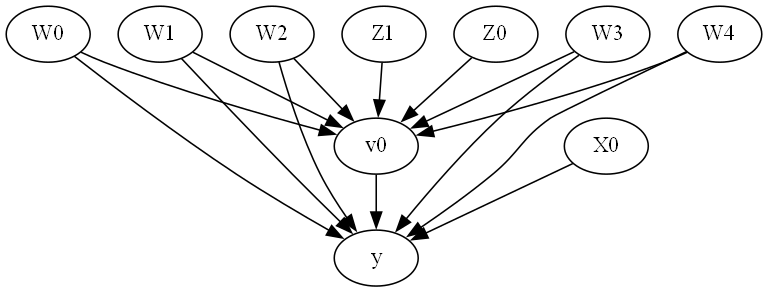

In [5]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W4,W2,U) = P(y|v0,W0,W3,W1,W4,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [7]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W4,W2,U) = P(y|v0,W0,W3,W1,W4,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W4+W2
Target units: ate

## Estimate
Mean value: 12.707785477422082

Causal Estimate is 12.707785477422082


In [8]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W4,W2,U) = P(y|v0,W0,W3,W1,W4,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W4+W2
Target units: atc

## Estimate
Mean value: 12.762241205982239

Causal Estimate is 12.762241205982239


In [9]:
# Without graph
model= CausalModel(
        data=df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        common_causes=data["common_causes_names"],
        effect_modifiers=data["effect_modifier_names"])

In [10]:
model.view_model()

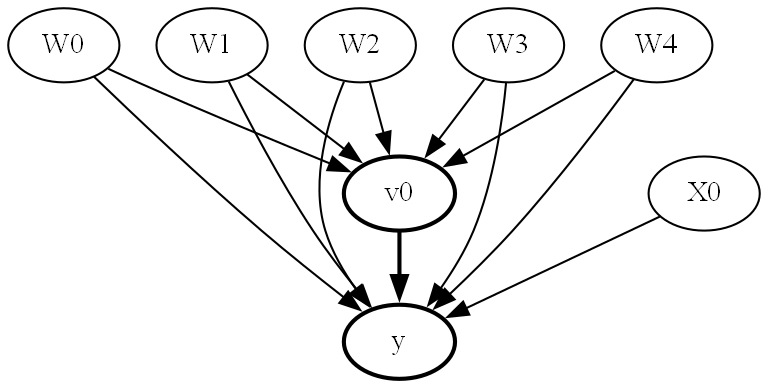

In [11]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [13]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W4,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W4,W2,U) = P(y|v0,W0,W3,W1,W4,W2)

## Realized estimand
b: y~v0+W0+W3+W1+W4+W2
Target units: ate

## Estimate
Mean value: 12.707785477422082

Causal Estimate is 12.707785477422082


In [14]:
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.707785477422082
New effect:12.707785477422078
p value:2.0



In [15]:
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.707785477422082
New effect:0.023060574302244473
p value:0.9



In [16]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.707785477422082
New effect:12.70944994309473
p value:0.94



In [17]:
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9, random_seed = 1)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.707785477422082
New effect:12.714499198753815
p value:0.94



In [18]:
res_unobserved=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.707785477422082
New effect:12.342139576868261



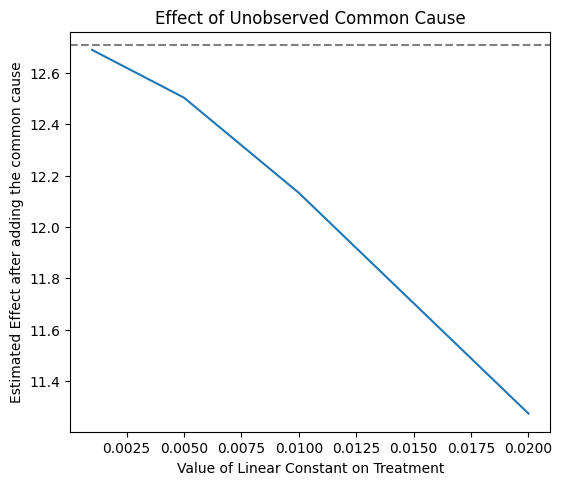

Refute: Add an Unobserved Common Cause
Estimated effect:12.707785477422082
New effect:(11.2732936337504, 12.689450232657258)



In [19]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=np.array([0.001, 0.005, 0.01, 0.02]), effect_strength_on_outcome=0.01)
print(res_unobserved_range)

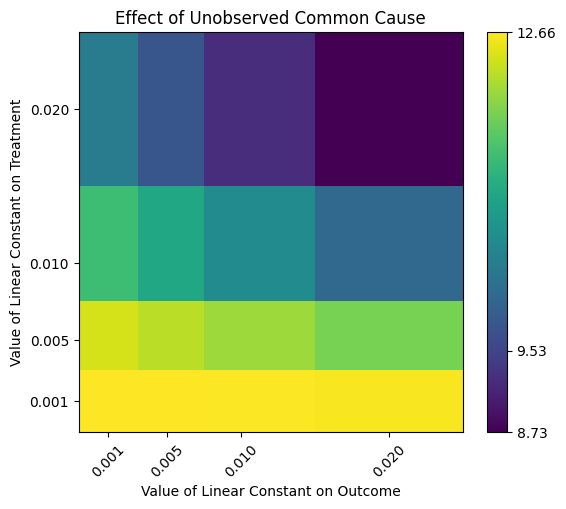

Refute: Add an Unobserved Common Cause
Estimated effect:12.707785477422082
New effect:(8.73118442829116, 12.66143364387174)



In [20]:
res_unobserved_range=model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                           effect_strength_on_treatment=[0.001, 0.005, 0.01, 0.02],
                                           effect_strength_on_outcome=[0.001, 0.005, 0.01,0.02])
print(res_unobserved_range)

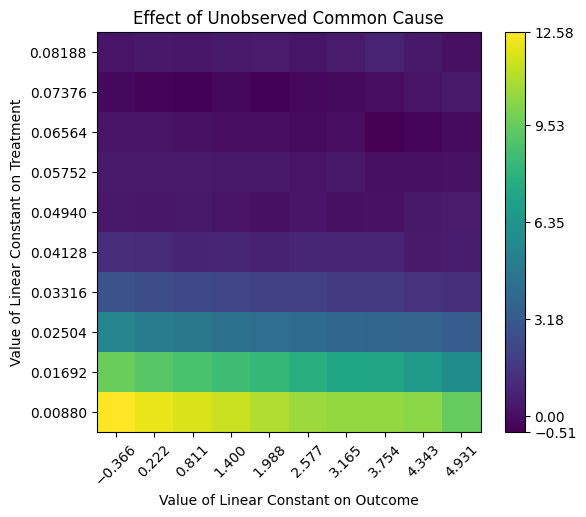

Refute: Add an Unobserved Common Cause
Estimated effect:12.707785477422082
New effect:(-0.5124670197979045, 12.580115843967159)



In [21]:
res_unobserved_auto = model.refute_estimate(identified_estimand, estimate, method_name="add_unobserved_common_cause",
                                           confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear")
print(res_unobserved_auto)